In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
#from os import listdir
import glob
import sncosmo
from ipywidgets import *
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from scipy.interpolate import (
    InterpolatedUnivariateSpline as Spline1d,
    RectBivariateSpline as Spline2d
)
from sncosmo.salt2utils import BicubicInterpolator
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.model_selection import cross_val_score
from warnings import filterwarnings
filterwarnings('ignore')

from tabulate import tabulate #to export in table format
%matplotlib inline

In [2]:
kernel = 0.5 * (RBF(length_scale=3, length_scale_bounds=(1, 30)) + WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-5,0.5)))

# Read the files

In [3]:
# file data paths
data_path = "./data/sp/"
file_names = glob.glob(data_path+"*.dat")
for i in range(0, len(file_names)):
    file_names[i] = file_names[i][10:]
print("Total files in path: ", len(file_names))

Total files in path:  2466


In [4]:
# auxiliar file 
sn_names = pd.read_csv("./data/list.dat",
                       header=None,
                       sep="\s+",
                       names=["name", "phase", "file_name"])
sn_names.head()

,name,phase,file_name
0,Test_SN0,-8.154,Test_SN0_0.dat
1,Test_SN0,-3.522,Test_SN0_1.dat
2,Test_SN0,17.959,Test_SN0_10.dat
3,Test_SN0,19.801,Test_SN0_11.dat
4,Test_SN0,19.816,Test_SN0_12.dat


In [5]:
names = sn_names["name"].unique()
print("Total number of sn files: ", len(names))

Total number of sn files:  171


# Training sample and simple graphs

In [6]:
w = widgets.Dropdown(
    options=names,
    value=names[0],
    description='SN name:',
    disabled=False,
)
display(w)

Dropdown(description='SN name:', options=('Test_SN0', 'Test_SN10', 'Test_SN11', 'Test_SN12', 'Test_SN13', 'Tes…

In [7]:
sn_spectra = glob.glob(data_path + w.value + "*.dat")

In [8]:
def spectra(i=0, plot=True):
    """
    function that returns the wavelenght, the flux and the flux error for a matplotlib graph or whatever spectra
    
    i = index of the element
    returns the wavelength, flux and flux error
    """
    if plot == True:
        data = sncosmo.read_lc(sn_spectra[i], format="salt2")
        return data["WAVE"], data["SN_SPEC"], data["SN_ERR"]
    else:
        data = sncosmo.read_lc(data_path+file_names[i], format="salt2")
        return data["WAVE"], data["SN_SPEC"], data["SN_ERR"]


## Spectra

In [9]:
# option list for jupyter lab widgets
optionslist = []
for i in range(0, len(sn_spectra)):
    optionslist.append(i)

def update_graph(i):
    """
    void function that updates a matplotlib graph
    """
    wave, flux, fluxe = spectra(i)
    plt.xlabel("$\lambda$  ($\AA$)")
    plt.ylabel("flux (erg/s/cm^2^/{AA} * random offset)")
    plt.plot(wave, flux, "k")
    
i = widgets.Dropdown(options=optionslist, value=0, description='Index: ', disabled=False)

widgets.interactive(update_graph,i=i) # to activate the interactive widget

interactive(children=(Dropdown(description='Index: ', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1…

## Monochromatic light curves

In [10]:
wave_number = 7000

time_lc = []
flux_lc = []

for i in range(0, len(sn_spectra)):
    wave, flux, fluxe = spectra(i)
    flux_lc.append(Spline1d(wave, flux,  k=1)(wave_number))
    time_lc.append(sn_names["phase"][sn_names["file_name"] == str(sn_spectra[i][10:])])

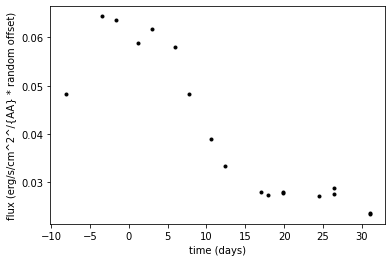

In [11]:
plt.plot(time_lc, flux_lc, "k.")
plt.xlabel("time (days)")
plt.ylabel("flux (erg/s/cm^2^/{AA} * random offset)");

## Training grid

In [12]:
"""
for i in range(0, len(file_names)):
    wave = spectra(i, plot=False)[0]
    phase = sn_names["phase"][sn_names["file_name"] == str(file_names[i])]
    plt.plot([phase,phase], [np.min(wave),np.max(wave)], 'k', linewidth=1)
    plt.xlabel("time (days)")
    plt.ylabel("$\lambda$ ($\AA$)")
    plt.xlim(-10, 50)
    plt.ylim(3500, 8500)
"""

'\nfor i in range(0, len(file_names)):\n    wave = spectra(i, plot=False)[0]\n    phase = sn_names["phase"][sn_names["file_name"] == str(file_names[i])]\n    plt.plot([phase,phase], [np.min(wave),np.max(wave)], \'k\', linewidth=1)\n    plt.xlabel("time (days)")\n    plt.ylabel("$\\lambda$ ($\\AA$)")\n    plt.xlim(-10, 50)\n    plt.ylim(3500, 8500)\n'

In [13]:
## Defining the grid
X_GRID = np.linspace(-10, 50, 61, dtype=int)
Y_GRID = np.linspace(3500, 8500, 501, dtype=int)

# Grid limits
print("time grid limits: ", np.min(X_GRID), ", ", np.max(X_GRID))
print("wavelenght grid limits: ", np.min(Y_GRID), ", ", np.max(Y_GRID))

time grid limits:  -10 ,  50
wavelenght grid limits:  3500 ,  8500


In [14]:
# split our data into a training and test dataset
#np.random.seed(42)
#sn_train, sn_test = train_test_split(names, test_size=0.001)
#print(len(sn_train), len(sn_test))

In [15]:
def gaussian_process(wave, flux, error=True):
    """
    function that performs a gaussian process in a dataset of monochromatic light curves
    wave: Python list that gives the wavelenghts
    flux: np array that gives the flux
    error: binary variable to return or not the covariance in gaussian process regression
    
    return the corresponding gaussian process on data
    """
    # set the gaussian process regressor
    gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0).fit(wave, flux)
    if error==True:
        return gp.predict(X_GRID[:, np.newaxis], return_cov=True) # return mean and covariance
    else:
        return gp.predict(X_GRID[:, np.newaxis], return_cov=False) # return only mean     


In [16]:
def prepare_data_to_GP(wave):
    """
    function that convert a np array into a Python list for a gaussian process regression in SK-Learn
    wave: np array that gives the wavelenghts
    
    return the wavelenght in a correct format
    """
    temp_wave = [] # a new python list
    for ii in range(0, len(wave)):
        temp_wave.append([wave[ii]]) # correct SK-Learn format
    return temp_wave

In [17]:
def spectra_train(n_file):
    """
    function that returns the wavelenght, the flux and the flux error for a matplotlib graph or whatever spectra
    
    n_file: file name
    returns the wavelength, flux and flux error
    """
    data = sncosmo.read_lc(n_file, format="salt2")
    return data["WAVE"], data["SN_SPEC"], data["SN_ERR"]

In [19]:
SPEC_TRAIN_FUN = []
SPEC_TRAIN_TIME = []
SPEC_TRAIN_MINMAX = []
for i in range(0, len(names)):
    SPEC_TRAIN_FUN.append([]) # for spectra function
    SPEC_TRAIN_TIME.append([]) # for spectra time
    SPEC_TRAIN_MINMAX.append([]) # for min max spectra (in wavelenghts)

In [20]:
for i in range(0, len(names)):
    sn_train_spectra = glob.glob(data_path + names[i] + "_*.dat")
    for j in range(0, len(sn_train_spectra)):
        wave, flux, eflux = spectra_train(sn_train_spectra[j]) # to get wave, flux and flux error
        Nyquist_frequecy=1/15 #approx
        cutoff=1/100 #freq
        #print(cutoff/Nyquist_frequecy)
        b, a = signal.butter(8, cutoff/Nyquist_frequecy, analog=False)
        filtered_flux=signal.filtfilt(b, a, flux, padlen=0)
        SPEC_TRAIN_FUN[i].append(Spline1d(wave, filtered_flux)) # to register the corresponding function
        SPEC_TRAIN_TIME[i].append(float(sn_names["phase"][sn_names["file_name"] == str(sn_train_spectra[j][10:])])) # to regirster the corresponding spectra time
        SPEC_TRAIN_MINMAX[i].append([float(np.min(wave)), float(np.max(wave))]) # to register min and max wavelength that function is available

In [21]:
SPEC_GRID = []
for i in range(0, len(names)):
    SPEC_GRID.append([]) # loop for each supernovae in trainingfrom scipy import signal

In [22]:
for i in range(0, len(SPEC_GRID)):
    for j in range(0, len(Y_GRID)):
        SPEC_GRID[i].append([[], []]) # for each supernovae and for each wavelengh we fill with time and flux lists
#SPEC_GRID[0][1][0]  # first sn, second wave list order, time or flux

In [23]:
for i in range(0, len(names)): # sn train index
    print(i+1, "/", len(names))
    for j in range(0, len(Y_GRID)): #  grid index
        for k in range(0, len(SPEC_TRAIN_FUN[i])): #func index
            if SPEC_TRAIN_MINMAX[i][k][0] < Y_GRID[j] < SPEC_TRAIN_MINMAX[i][k][1]: # if it's inside the bounds
                SPEC_GRID[i][j][0].append([SPEC_TRAIN_TIME[i][k]]) # time
                SPEC_GRID[i][j][1].append(np.float(SPEC_TRAIN_FUN[i][k](Y_GRID[j]))) # flux

1 / 171
2 / 171
3 / 171
4 / 171
5 / 171
6 / 171
7 / 171
8 / 171
9 / 171
10 / 171
11 / 171
12 / 171
13 / 171
14 / 171
15 / 171
16 / 171
17 / 171
18 / 171
19 / 171
20 / 171
21 / 171
22 / 171
23 / 171
24 / 171
25 / 171
26 / 171
27 / 171
28 / 171
29 / 171
30 / 171
31 / 171
32 / 171
33 / 171
34 / 171
35 / 171
36 / 171
37 / 171
38 / 171
39 / 171
40 / 171
41 / 171
42 / 171
43 / 171
44 / 171
45 / 171
46 / 171
47 / 171
48 / 171
49 / 171
50 / 171
51 / 171
52 / 171
53 / 171
54 / 171
55 / 171
56 / 171
57 / 171
58 / 171
59 / 171
60 / 171
61 / 171
62 / 171
63 / 171
64 / 171
65 / 171
66 / 171
67 / 171
68 / 171
69 / 171
70 / 171
71 / 171
72 / 171
73 / 171
74 / 171
75 / 171
76 / 171
77 / 171
78 / 171
79 / 171
80 / 171
81 / 171
82 / 171
83 / 171
84 / 171
85 / 171
86 / 171
87 / 171
88 / 171
89 / 171
90 / 171
91 / 171
92 / 171
93 / 171
94 / 171
95 / 171
96 / 171
97 / 171
98 / 171
99 / 171
100 / 171
101 / 171
102 / 171
103 / 171
104 / 171
105 / 171
106 / 171
107 / 171
108 / 171
109 / 171
110 / 171
111 / 17

In [24]:
"""
Nsn = 30
Nspec = 100
TIME_TEMP = SPEC_GRID[Nsn][Nspec][0]
FLUX_TEMP = SPEC_GRID[Nsn][Nspec][1]

gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0).fit(TIME_TEMP, FLUX_TEMP)
y_mean, y_cov = gp.predict(X_GRID[:, np.newaxis], return_cov=True) 

plt.plot(X_GRID, y_mean, 'k', lw=3, zorder=9)
plt.fill_between(X_GRID, y_mean - np.sqrt(np.diag(y_cov)), y_mean + np.sqrt(np.diag(y_cov)), alpha=0.5, color='k')
plt.scatter(TIME_TEMP, FLUX_TEMP, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.xlabel("time (days)")
plt.ylabel("flux (a.u)")
"""

'\nNsn = 30\nNspec = 100\nTIME_TEMP = SPEC_GRID[Nsn][Nspec][0]\nFLUX_TEMP = SPEC_GRID[Nsn][Nspec][1]\n\ngp = GaussianProcessRegressor(kernel=kernel, alpha=0.0).fit(TIME_TEMP, FLUX_TEMP)\ny_mean, y_cov = gp.predict(X_GRID[:, np.newaxis], return_cov=True) \n\nplt.plot(X_GRID, y_mean, \'k\', lw=3, zorder=9)\nplt.fill_between(X_GRID, y_mean - np.sqrt(np.diag(y_cov)), y_mean + np.sqrt(np.diag(y_cov)), alpha=0.5, color=\'k\')\nplt.scatter(TIME_TEMP, FLUX_TEMP, c=\'r\', s=50, zorder=10, edgecolors=(0, 0, 0))\nplt.xlabel("time (days)")\nplt.ylabel("flux (a.u)")\n'

In [25]:
data_NSPEC_CUT = 7 # minimum number of spectra
data_NWAVE_CUT = 200 # wavelengh in a commom grid
SN_TRAIN = []
SN_TRAIN_ERROR = []
for i in range(0, len(names)):
        SN_TRAIN.append([])
        SN_TRAIN_ERROR.append([])

In [26]:
for i in range(0, len(SPEC_GRID)):
    print(i+1, "/", len(SPEC_GRID))
    if len(SPEC_GRID[i][data_NWAVE_CUT][0]) > data_NSPEC_CUT:
        for j in range(0, len(Y_GRID)):
            TIME_TEMP = SPEC_GRID[i][j][0]
            FLUX_TEMP = SPEC_GRID[i][j][1]
            FLUX_TEMP, FLUX_ERROR_TEMP = gaussian_process(TIME_TEMP, FLUX_TEMP, error=True) # the brand new monochromatic light curves
            FLUX_ERROR_TEMP = np.sqrt(np.diag(FLUX_ERROR_TEMP))
            for k in range(0, len(FLUX_TEMP)):
                SN_TRAIN[i].append(FLUX_TEMP[k])
                SN_TRAIN_ERROR[i].append(FLUX_ERROR_TEMP[k])

1 / 171
2 / 171
3 / 171
4 / 171
5 / 171
6 / 171
7 / 171
8 / 171
9 / 171
10 / 171
11 / 171
12 / 171
13 / 171
14 / 171
15 / 171
16 / 171
17 / 171
18 / 171
19 / 171
20 / 171
21 / 171
22 / 171
23 / 171
24 / 171
25 / 171
26 / 171
27 / 171
28 / 171
29 / 171
30 / 171
31 / 171
32 / 171
33 / 171
34 / 171
35 / 171
36 / 171
37 / 171
38 / 171
39 / 171
40 / 171
41 / 171
42 / 171
43 / 171
44 / 171
45 / 171
46 / 171
47 / 171
48 / 171
49 / 171
50 / 171
51 / 171
52 / 171
53 / 171
54 / 171
55 / 171
56 / 171
57 / 171
58 / 171
59 / 171
60 / 171
61 / 171
62 / 171
63 / 171
64 / 171
65 / 171
66 / 171
67 / 171
68 / 171
69 / 171
70 / 171
71 / 171
72 / 171
73 / 171
74 / 171
75 / 171
76 / 171
77 / 171
78 / 171
79 / 171
80 / 171
81 / 171
82 / 171
83 / 171
84 / 171
85 / 171
86 / 171
87 / 171
88 / 171
89 / 171
90 / 171
91 / 171
92 / 171
93 / 171
94 / 171
95 / 171
96 / 171
97 / 171
98 / 171
99 / 171
100 / 171
101 / 171
102 / 171
103 / 171
104 / 171
105 / 171
106 / 171
107 / 171
108 / 171
109 / 171
110 / 171
111 / 17

In [27]:
X_export = []
Y_export = []
for i in range(0, len(Y_GRID)):
    for j in range(0, len(X_GRID)):
        X_export.append(X_GRID[j])
        Y_export.append(Y_GRID[i])

In [28]:
save_path = 'C:\\Users\\joao\\Documents\\GitHub\\SNFACTORY_SNTRAIN\\SN_surfaces\\'

In [49]:
for i in range(0, len(names)):
    print(i)
    table = []
    if len(SN_TRAIN[i]) > 0:
        for n in range(0, len(X_export)):
            table.append((X_export[n], Y_export[n], SN_TRAIN[i][n], SN_TRAIN_ERROR[i][n]))

        completeName = os.path.join(save_path, str(names[i])+".dat")

        f = open(completeName, 'w')
        f.write(tabulate(table, tablefmt="plain"))
        f.close()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
